The AB test is a randomized experiment that is used by most large companies to evaluate the launch of new functionality. Various difficulties may arise in the analysis and conduct of the experiment. Several typical problematic cases from real life are given in this dataset and analysis.

### Content
1. [Loading and processing data](#Loading)
2. [Statistical Analysis](#Statistical)
3. [Conclusions](#Conclusions)

### Loading and processing data <a name="Loading"/>

Let's import the necessary libraries and load the data

In [ ]:
import numpy as np
import pandas as pd
from scipy.stats import mannwhitneyu
from scipy.stats import ttest_ind
from scipy.stats import norm
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm.auto import tqdm
import seaborn as sns
from scipy.stats import pearsonr
from scipy.stats import shapiro

In [ ]:
# TODO : import the dataset
from google.colab import files
uploaded = files.upload()

Saving AB_Test_Results.csv to AB_Test_Results.csv


In [ ]:
# TODO : take a quick look at the data
df = pd.read_csv('AB_Test_Results.csv')
df.head()

,USER_ID,VARIANT_NAME,REVENUE
0,737,variant,0.0
1,2423,control,0.0
2,9411,control,0.0
3,7311,control,0.0
4,6174,variant,0.0


Let's see if there are users who have two A/B test groups

In [ ]:
# TODO : Look at the distribution of the number of unique groups for each user
user_group_counts = (
    df.groupby("USER_ID")["VARIANT_NAME"]
      .nunique()
      .reset_index(name="unique_groups")
)

user_group_counts.head()
distribution = (
    user_group_counts["unique_groups"]
      .value_counts()
      .sort_index()
      .reset_index()
)

distribution.columns = ["unique_groups", "number_of_users"]
distribution


,unique_groups,number_of_users
0,1,4783
1,2,1541


In [ ]:
# TODO : Look at the distribution of the number of unique groups for each user in relative terms
user_group_counts = (
    df.groupby("USER_ID")["VARIANT_NAME"]
      .nunique()
      .reset_index(name="unique_groups")
)

relative_distribution = (
    user_group_counts["unique_groups"]
      .value_counts(normalize=True)   # relative terms
      .sort_index()
      .reset_index()
)

relative_distribution.columns = ["unique_groups", "proportion"]
relative_distribution["percentage"] = relative_distribution["proportion"] * 100

relative_distribution

,unique_groups,proportion,percentage
0,1,0.756325,75.632511
1,2,0.243675,24.367489


What can you observe ? Should we exclude these users ? Why ?

In [ ]:
# TODO : users have 1 A/B test group ?

# No — not all users have only 1 A/B test group.

# TODO : Take only these users
# Yes — for a valid A/B analysis, you should take only those users who belong to exactly one group.

In [ ]:
# TODO : Leave only records with users with the 1st ab test group
# TODO : Check that the number of users matches what it was before the exception


In [ ]:
# Identify users that belong to exactly one A/B group
single_group_users = (
    df.groupby("USER_ID")["VARIANT_NAME"]
      .nunique()
      .loc[lambda x: x == 1]
      .index
)

# Filter dataset to keep only those users
clean_df = df[df["USER_ID"].isin(single_group_users)]

In [ ]:
users_before = df["USER_ID"].nunique()
users_before

6324

In [ ]:
#after filtering
users_after = clean_df["USER_ID"].nunique()
users_after

4783

In [ ]:
print(f"Users before filtering: {users_before}")
print(f"Users after filtering:  {users_after}")
print(f"Users removed:          {users_before - users_after}")

Users before filtering: 6324
Users after filtering:  4783
Users removed:          1541


Let's see how the data is distributed

<Figure size 640x480 with 0 Axes>

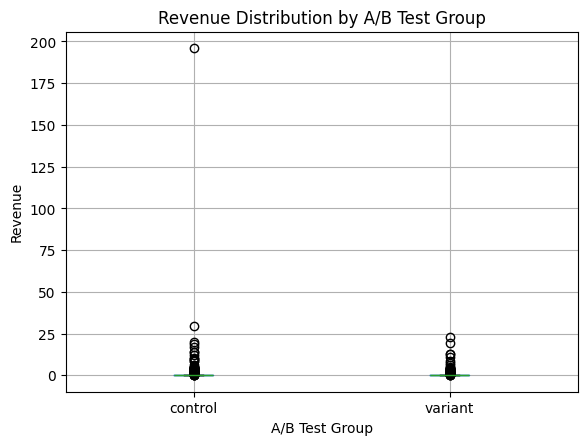

In [ ]:
# TODO : Check how the data is distributed using a box plot
plt.figure()
clean_df.boxplot(column="REVENUE", by="VARIANT_NAME")
plt.title("Revenue Distribution by A/B Test Group")
plt.suptitle("")  # remove default subtitle
plt.xlabel("A/B Test Group")
plt.ylabel("Revenue")
plt.show()

It can be seen that there is a strong outlier in the data - we will find it by sorting these revenue values in descending order

In [ ]:
# TODO : Sort these revenue values in descending order
df['REVENUE'].sort_values(ascending=False)

,REVENUE
1437,196.01
6447,58.63
7642,57.46
9421,41.53
8168,29.32
...,...
3356,0.00
3357,0.00
3358,0.00
3359,0.00


In [ ]:
# TODO : See if user 3342 had other events with a strong outlier
df[df['USER_ID'] == 3342]

,USER_ID,VARIANT_NAME,REVENUE
1437,3342,control,196.01


We see that there is only one outlier - in conditions of limited information, we will remove this entry and look at the distribution of data again

<Figure size 640x480 with 0 Axes>

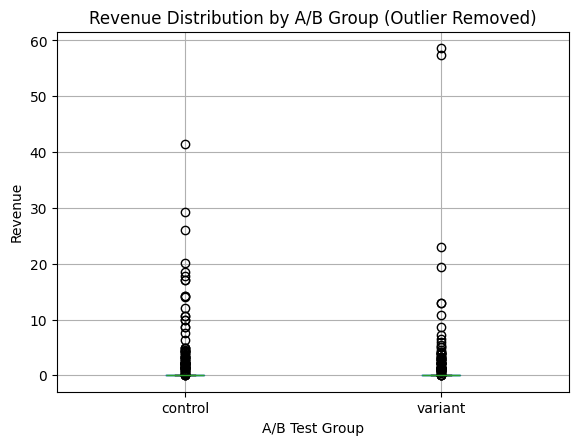

In [ ]:
# TODO : We see that there is only one outlier - in conditions of limited information, remove this entry and visualize the distribution of data again.
clean_df = df[df['USER_ID'] != 3342]
plt.figure()
clean_df.boxplot(column="REVENUE", by="VARIANT_NAME")
plt.title("Revenue Distribution by A/B Group (Outlier Removed)")
plt.suptitle("")
plt.xlabel("A/B Test Group")
plt.ylabel("Revenue")
plt.show()


What can you say about the users and their purchases ?

In [ ]:
# TODO : Check if there are users who have records with zero and positive revenue
# Group by user and check if they have both 0 and >0 revenue
users_with_mixed_revenue = (
    clean_df.groupby("USER_ID")["REVENUE"]
    .apply(lambda x: (x == 0).any() and (x > 0).any())
)

# Keep only users where this is True
mixed_revenue_users = users_with_mixed_revenue[users_with_mixed_revenue].index

In [ ]:
len(mixed_revenue_users)

91

In [ ]:
clean_df[clean_df["USER_ID"].isin(mixed_revenue_users)].head(10)


,USER_ID,VARIANT_NAME,REVENUE
13,2529,variant,2.15
19,8927,variant,0.00
49,6429,control,3.25
110,6207,control,0.00
139,3331,variant,4.27
182,6678,variant,0.00
204,443,variant,0.00
296,9661,variant,0.00
312,5205,variant,0.00
333,8020,control,9.91


Can a user have records with both zero and positive revenue ?

Let's make the assumption that the records are user visits to the service, and the experimental unit is users.


In [ ]:
# TODO : Group the data for each user and sum the revenue for each to get one record per user
# Aggregate to user level
user_level_df = (
    clean_df
    .groupby(["USER_ID", "VARIANT_NAME"], as_index=False)
    .agg(
        total_revenue=("REVENUE", "sum")
    )
)

user_level_df.head()

,USER_ID,VARIANT_NAME,total_revenue
0,2,control,0.0
1,3,control,0.0
2,3,variant,0.0
3,4,variant,0.0
4,5,variant,0.0


<Figure size 640x480 with 0 Axes>

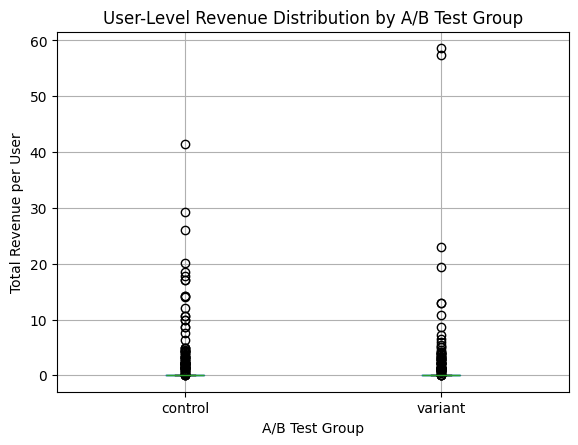

In [ ]:
# TODO : Visualize the resulting distribution of the data again.
plt.figure()
user_level_df.boxplot(column="total_revenue", by="VARIANT_NAME")
plt.title("User-Level Revenue Distribution by A/B Test Group")
plt.suptitle("")  # remove automatic subtitle
plt.xlabel("A/B Test Group")
plt.ylabel("Total Revenue per User")
plt.show()

It should be noted that during the transformation, the quantiles in the test group increased

It can be seen that in the test group, almost all quantile statistics, except for the minimum, are at a slightly lower level.

Let's look at various statistics in the context of AB test groups for all users

In [ ]:
# TODO : get metrics by groups
metrics_by_group = (
    user_level_df
    .groupby("VARIANT_NAME")
    .agg(
        users=("USER_ID", "nunique"),
        total_revenue=("total_revenue", "sum"),
        avg_revenue_per_user=("total_revenue", "mean"),
        median_revenue_per_user=("total_revenue", "median"),
        conversion_rate=("total_revenue", lambda x: (x > 0).mean())
    )
    .reset_index()
)

metrics_by_group


,VARIANT_NAME,users,total_revenue,avg_revenue_per_user,median_revenue_per_user,conversion_rate
0,control,3930,446.99,0.113738,0.0,0.020102
1,variant,3934,351.47,0.089342,0.0,0.018048


In [ ]:
# TODO : create two additional metrics to see relative changes
control_metrics = metrics_by_group[
    metrics_by_group["VARIANT_NAME"] == "control"
].iloc[0]

control_avg_revenue = control_metrics["avg_revenue_per_user"]
control_conversion = control_metrics["conversion_rate"]

#adding relative metric
metrics_by_group["relative_change_avg_revenue_%"] = (
    (metrics_by_group["avg_revenue_per_user"] - control_avg_revenue)
    / control_avg_revenue * 100
)

metrics_by_group["relative_change_conversion_rate_%"] = (
    (metrics_by_group["conversion_rate"] - control_conversion)
    / control_conversion * 100
)

metrics_by_group


,VARIANT_NAME,users,total_revenue,avg_revenue_per_user,median_revenue_per_user,conversion_rate,relative_change_avg_revenue_%,relative_change_conversion_rate_%
0,control,3930,446.99,0.113738,0.0,0.020102,0.000000,0.000000
1,variant,3934,351.47,0.089342,0.0,0.018048,-21.449555,-10.217963


In [ ]:
# TODO : add them to the rest of the metrics in a separate group
absolute_metrics = metrics_by_group[[
    "VARIANT_NAME",
    "users",
    "total_revenue",
    "avg_revenue_per_user",
    "median_revenue_per_user",
    "conversion_rate"
]].copy()

absolute_metrics["metric_group"] = "absolute"
absolute_metrics

,VARIANT_NAME,users,total_revenue,avg_revenue_per_user,median_revenue_per_user,conversion_rate,metric_group
0,control,3930,446.99,0.113738,0.0,0.020102,absolute
1,variant,3934,351.47,0.089342,0.0,0.018048,absolute


In [ ]:
#relative metrics
relative_metrics = metrics_by_group[[
    "VARIANT_NAME",
    "relative_change_avg_revenue_%",
    "relative_change_conversion_rate_%"
]].copy()

relative_metrics["metric_group"] = "relative"
relative_metrics

,VARIANT_NAME,relative_change_avg_revenue_%,relative_change_conversion_rate_%,metric_group
0,control,0.000000,0.000000,relative
1,variant,-21.449555,-10.217963,relative


What can you see in the test group about the total amount of revenue, the average check per user, and the number of orders per user slightly increased ?

Let's also see how paying users behave :

In [ ]:
# TODO : get metrics by groups
paying_users_df = user_level_df[user_level_df["total_revenue"] > 0]

paying_metrics_by_group = (
    paying_users_df
    .groupby("VARIANT_NAME")
    .agg(
        paying_users=("USER_ID", "nunique"),
        total_revenue=("total_revenue", "sum"),
        avg_revenue_per_paying_user=("total_revenue", "mean"),
        median_revenue_per_paying_user=("total_revenue", "median")
    )
    .reset_index()
)

paying_metrics_by_group


,VARIANT_NAME,paying_users,total_revenue,avg_revenue_per_paying_user,median_revenue_per_paying_user
0,control,79,446.99,5.658101,2.93
1,variant,71,351.47,4.950282,2.24


In [ ]:
control_row = paying_metrics_by_group[
    paying_metrics_by_group["VARIANT_NAME"] == "control"
].iloc[0]

control_avg_payer_revenue = control_row["avg_revenue_per_paying_user"]
control_median_payer_revenue = control_row["median_revenue_per_paying_user"]


# TODO : add them to the rest of the metrics in a separate group
paying_metrics_by_group["relative_change_avg_revenue_per_payer_%"] = (
    (paying_metrics_by_group["avg_revenue_per_paying_user"]
     - control_avg_payer_revenue)
    / control_avg_payer_revenue * 100
)

paying_metrics_by_group["relative_change_median_revenue_per_payer_%"] = (
    (paying_metrics_by_group["median_revenue_per_paying_user"]
     - control_median_payer_revenue)
    / control_median_payer_revenue * 100
)

paying_metrics_by_group


,VARIANT_NAME,paying_users,total_revenue,avg_revenue_per_paying_user,median_revenue_per_paying_user,relative_change_avg_revenue_per_payer_%,relative_change_median_revenue_per_payer_%
0,control,79,446.99,5.658101,2.93,0.000000,0.000000
1,variant,71,351.47,4.950282,2.24,-12.509843,-23.549488


Let's look at the distributions of all and only paying users

/tmp/ipython-input-4101851425.py:3: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(df.loc[df['VARIANT_NAME'] == 'control', 'REVENUE'], ax = axes[0], label='control')
/tmp/ipython-input-4101851425.py:4: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(df.loc[df['VARIANT_NAME'] == 'variant', 'REVENUE'

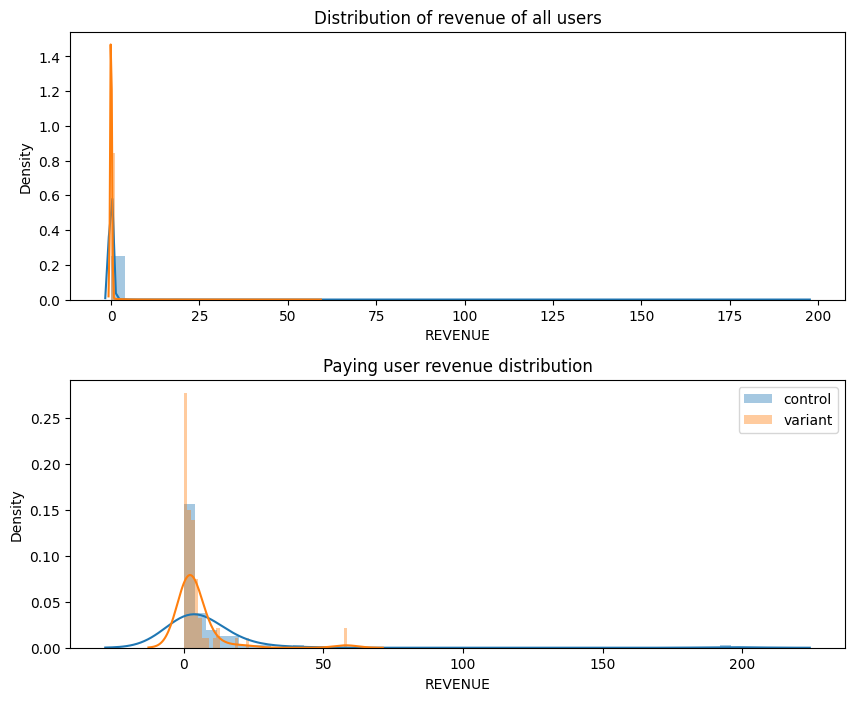

In [ ]:
f, axes = plt.subplots(2, figsize=(10,8))
# build graphs of distributions of all users
sns.distplot(df.loc[df['VARIANT_NAME'] == 'control', 'REVENUE'], ax = axes[0], label='control')
sns.distplot(df.loc[df['VARIANT_NAME'] == 'variant', 'REVENUE'], ax = axes[0], label='variant')
axes[0].set_title('Distribution of revenue of all users')

# build graphs of distributions of paying users
sns.distplot(df.loc[(df['VARIANT_NAME'] == 'control') & (df['REVENUE'] > 0), 'REVENUE'], ax = axes[1], label='control' )
sns.distplot(df.loc[(df['VARIANT_NAME'] == 'variant') & (df['REVENUE'] > 0), 'REVENUE'], ax = axes[1], label='variant' )
axes[1].set_title('Paying user revenue distribution')
plt.legend()
plt.subplots_adjust(hspace = 0.3)

### Statistical Analysis <a name="Statistical"/>

#### Checking if the distribution is normal

Based on their previous graph, we see that the data is not normally distributed.

In [ ]:
# TODO : Use the Shapiro-Wilk criterion to confirm it
shapiro_results = {}

for group in user_level_df["VARIANT_NAME"].unique():
    data = user_level_df[
        user_level_df["VARIANT_NAME"] == group
    ]["total_revenue"]

    stat, p_value = shapiro(data)
    shapiro_results[group] = {
        "W_statistic": stat,
        "p_value": p_value
    }

shapiro_results


{'control': {'W_statistic': np.float64(0.06129388898754595),
  'p_value': np.float64(4.797646165523811e-88)},
 'variant': {'W_statistic': np.float64(0.03283846234982246),
  'p_value': np.float64(9.573944628034371e-89)}}

Is the null hypothesis about the normal distribution of the data rejected ?

#### Mann-Whitney test

Let's check the value of the statistics of the Mann-Whitney test. Some sources have a limitation of applicability in case of duplicate data. There are a lot of repetitions in our sample, and especially a lot of zero values, so in this case we need to be careful about this criterion.

In [ ]:
(df['REVENUE'] == 0).value_counts()

,count
REVENUE,
True,9848
False,152


In [ ]:
# TODO : Check on the data of all users the value of the statistics of the Mann-Whitney test
control_data = user_level_df[
    user_level_df["VARIANT_NAME"] == "control"
]["total_revenue"]

variant_data = user_level_df[
    user_level_df["VARIANT_NAME"] == "variant"
]["total_revenue"]

u_statistic, p_value = mannwhitneyu(
    control_data,
    variant_data,
    alternative="two-sided"
)

u_statistic, p_value


(np.float64(7746585.5), np.float64(0.4950055422278089))

In [ ]:
# TODO : Check on the data of only the users that pay, the value of the statistics of the Mann-Whitney test
paying_users_df = user_level_df[user_level_df["total_revenue"] > 0]

control_payers = paying_users_df[
    paying_users_df["VARIANT_NAME"] == "control"
]["total_revenue"]

variant_payers = paying_users_df[
    paying_users_df["VARIANT_NAME"] == "variant"
]["total_revenue"]

from scipy.stats import mannwhitneyu

u_statistic, p_value = mannwhitneyu(
    control_payers,
    variant_payers,
    alternative="two-sided"
)

u_statistic, p_value


(np.float64(3202.0), np.float64(0.13499330293763107))

#### Bootstrap

In order to get more complete information about the differences between the average values of the ab test groups, we will use bootstap.

Let's create a function to get back samples and get a confidence interval, and then look at the sample statistics

In [ ]:
def get_bootstrap_samples(data, n_samples=1000):
    indices = np.random.randint(0, len(data), (n_samples, len(data)))
    samples = data[indices]
    return samples

def stat_intervals(stat, alpha=0.05):
    boundaries = np.percentile(stat, [100 * alpha / 2., 100 * (1 - alpha / 2.)])
    return boundaries

In [ ]:
# TODO : Generate samples for all users
control_data = user_level_df[
    user_level_df["VARIANT_NAME"] == "control"
]["total_revenue"].values

variant_data = user_level_df[
    user_level_df["VARIANT_NAME"] == "variant"
]["total_revenue"].values

n_bootstraps = 10_000

control_samples = np.random.choice(
    control_data,
    size=(n_bootstraps, len(control_data)),
    replace=True
)

variant_samples = np.random.choice(
    variant_data,
    size=(n_bootstraps, len(variant_data)),
    replace=True
)
control_means = control_samples.mean(axis=1)
variant_means = variant_samples.mean(axis=1)

mean_diff_distribution = variant_means - control_means
mean_diff_distribution.mean(), np.percentile(mean_diff_distribution, [2.5, 97.5])


(np.float64(-0.024528072876637552), array([-0.08429968,  0.039272  ]))

In [ ]:
# TODO : Generate samples for only paying users
paying_users_df = user_level_df[user_level_df["total_revenue"] > 0]

control_payers = paying_users_df[
    paying_users_df["VARIANT_NAME"] == "control"
]["total_revenue"].values

variant_payers = paying_users_df[
    paying_users_df["VARIANT_NAME"] == "variant"
]["total_revenue"].values


n_bootstraps = 10_000

control_payer_samples = np.random.choice(
    control_payers,
    size=(n_bootstraps, len(control_payers)),
    replace=True
)

variant_payer_samples = np.random.choice(
    variant_payers,
    size=(n_bootstraps, len(variant_payers)),
    replace=True
)

control_payer_means = control_payer_samples.mean(axis=1)
variant_payer_means = variant_payer_samples.mean(axis=1)

payer_mean_diff_distribution = (
    variant_payer_means - control_payer_means
)

payer_mean_diff_distribution

array([ 0.14185951,  0.31151899,  0.55321983, ..., -0.22594402,
       -0.44550187, -1.65246033])

Let's look at the distribution of means in the ab test groups

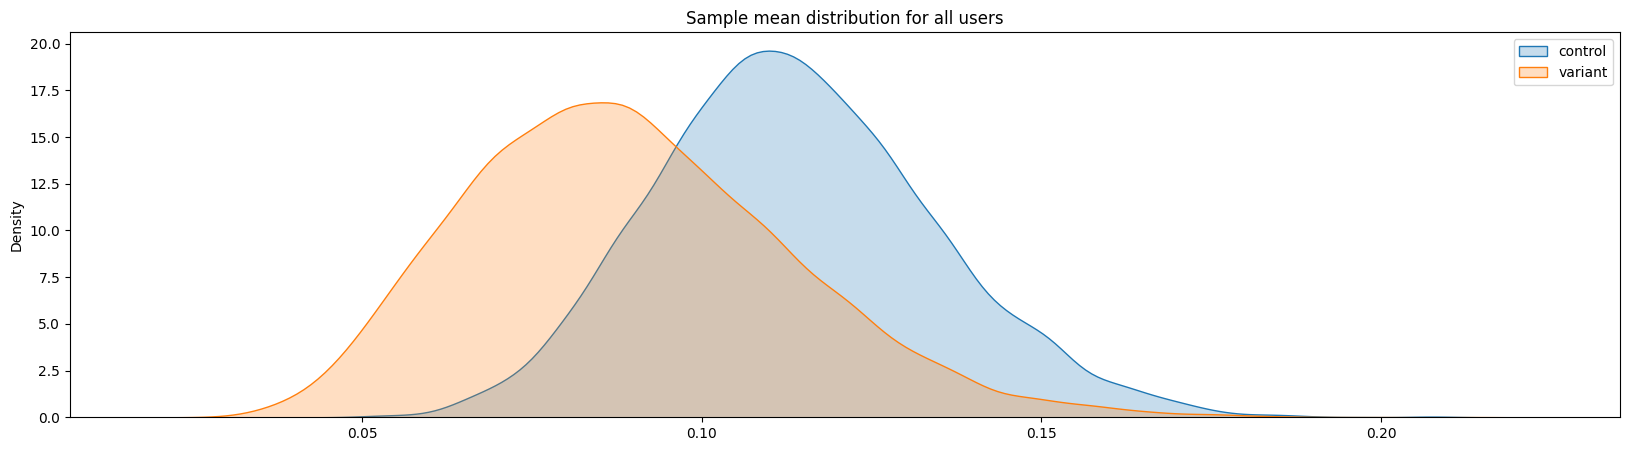

In [ ]:
plt.figure(figsize=(20,5))
sns.kdeplot(control_means, fill=True, label='control')
sns.kdeplot(variant_means, fill=True, label='variant')
plt.title('Sample mean distribution for all users')
plt.legend()
plt.show()

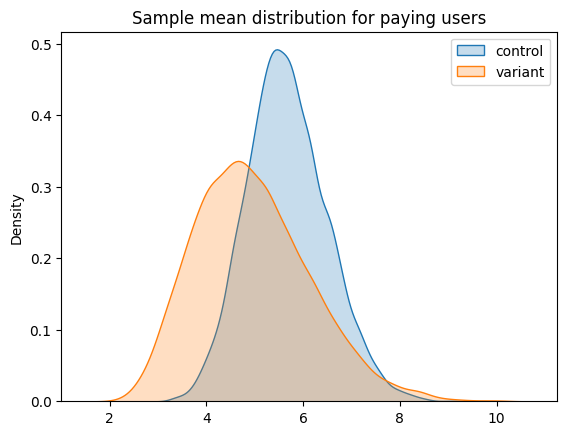

In [ ]:
f, ax = plt.subplots()
sns.kdeplot(control_payer_means, fill=True, label='control')
sns.kdeplot(variant_payer_means, fill=True, label='variant')
plt.title('Sample mean distribution for paying users')
plt.legend()
plt.show()

Do you see any difference ? What about the confidence intervals ? Conclude.

Let's evaluate the difference between the groups: look at the distribution of the mean difference and build confidence intervals for it. To do this, we will create a function for visualization

In [ ]:
def plot_distribution_and_stat_intervals(variant, control, title, alpha=0.05):
    """ Plot the distribution of the mean difference and return the confidence intervals """
    f, ax = plt.subplots()
    # Draw the kdeplot and get the Axes object
    sns.kdeplot(variant - control, fill=True, ax=ax)

    # Extract x and y data from the drawn plot
    # When fill=True, kdeplot creates a PolyCollection in ax.collections
    # We need to get the path from this collection.
    if ax.collections:
        # Get the first collection (PolyCollection) and its first path
        path = ax.collections[0].get_paths()[0]
        x, y = path.vertices.T # Transpose to get x and y arrays
    elif ax.lines: # Fallback in case kdeplot still produces a Line2D object
        x, y = ax.lines[0].get_data()
    else:
        raise ValueError("Could not extract KDE plot data: no lines or collections found.")

    ymin, ymax = ax.get_ylim() # Use ax.get_ylim() after kdeplot to get proper y-limits
    # highlight the zero value and the bounds of the confidence interval
    ax.vlines(0, 0, ymax, label='0', color='gray')
    conf_interval = stat_intervals(variant - control, alpha)
    ax.vlines(conf_interval[0], 0, ymax, linestyles="dashed")
    ax.vlines(conf_interval[1], 0, ymax, linestyles="dashed")
    # color the confidence interval and zones outside it
    ax.fill_between(x, y,
                     where = (x >= conf_interval[1]),
                     color='gainsboro')
    ax.fill_between(x, y,
                     where = (x <= conf_interval[0]),
                     color='gainsboro')
    ax.fill_between(x, y,
                     where = ((x >= conf_interval[0])
                              & (x <= conf_interval[1])),
                     color='red',
                     label = f'{100*(1-alpha)}% confidence interval')

    ax.set_title(f'Distribution of difference between means (variant - control) {title}; {100*(1-alpha)}% Confidence interval for difference of means: {conf_interval}')
    ax.legend(prop={'size':13})
    # return confidence interval data
    return conf_interval

Let's build a graph of the distribution of the difference in the means and get a confidence interval

For all users

array([-0.08429968,  0.039272  ])

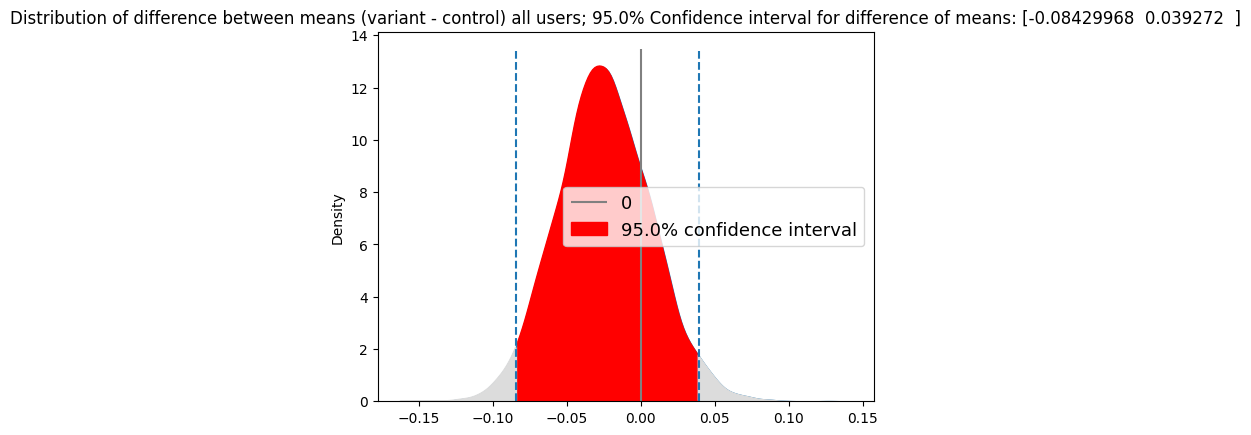

In [ ]:
plot_distribution_and_stat_intervals(variant_means,
                                     control_means,
                                     title='all users')

array([-3.43033134,  2.32090979])

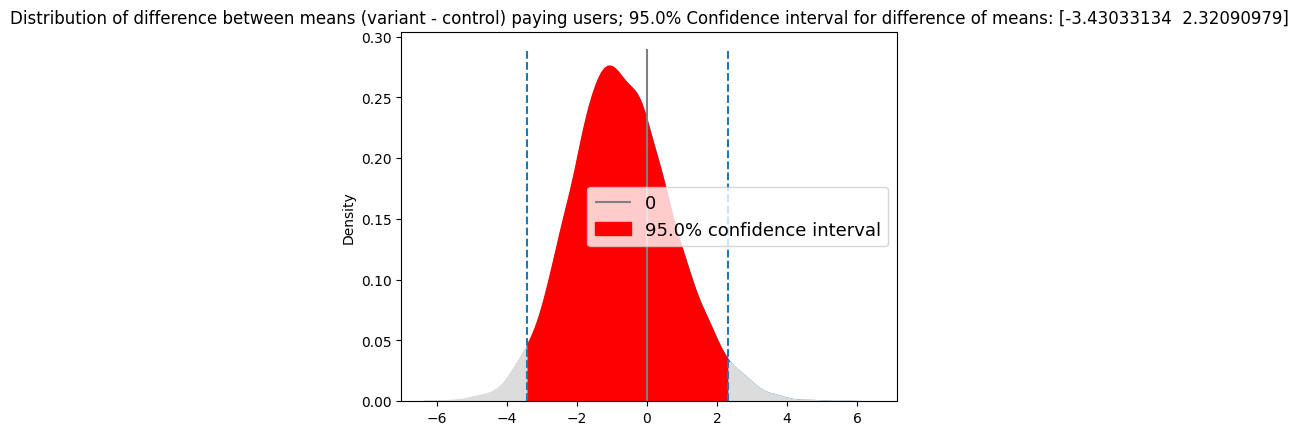

In [ ]:
plot_distribution_and_stat_intervals(variant_payer_means,
                                     control_payer_means,
                                     title='paying users')

What can you observe ? Conclude about the statistical change in average revenue between A/B test groups.


Based on the bootstrap analysis of the average revenue per user, for both all users and only paying users, the 95% confidence intervals for the difference in means between the variant and control groups included zero. This indicates that there is no statistically significant difference in the average revenue between the A/B test groups. The observed differences are likely due to random chance, and we cannot conclude that the variant had a significant impact on average revenue.